# Linear Least Squares (L2, MSE) Binary Classifier

In this notebook, we will consider a linear classifier for two classes.  

The discriminant function is
$$g({\bf x}) = {\bf w}^T {\bf x} + w_0$$
This function is compared against 0 to make the class decision.  Specifically, if $g({\bf x}) > 0 $, then ${\bf x}$ is classified to class 1, otherwise it is classified as class 2.  

In the least squares classifier, we convert the classification into a to a least squares regression problem.  We do so by setting the target for the $i^{th}$ data vector ${\bf x}_i$ to $y_i = +1$ if ${\bf x}_i$ is from class 1 and $y_i = +1$ if ${\bf x}_i$ is from class 2.  We will find a solution to this regression problem and then classify based on the sign of $\hat{y}({\bf x})$ -- i.e., decide class 1 if $\hat{y}({\bf x})> 0$ and decide class 2 otherwise.  

**NOTE:** We will see more details on this later in the class, so don't worry if the details that follow are a bit fuzzy.  I like to use computational examples to "preview" analytical results that we will see later in the class.

Specifically, we seek the parameters $$\{w_0, w_1, \ldots w_{D} \}$$ that minimize
$$J( \tilde{\bf w}) = \frac{1}{N_{\mathrm{train}}} \sum_{i=1}^{N_{\mathrm{train}}} [y_i - ({\bf w}^T {\bf x} + w_0)]^2 = \frac{1}{N_{\mathrm{train}}} \sum_{i=1}^{N_{\mathrm{train}}} [y_i - \tilde{\bf w}^T \tilde{\bf x}]^2$$
where we have implictly defined
$$ \tilde{\bf w} =  \left[  \begin{array}{c} w_0 \\ w_1 \\ \vdots \\  w_D \end{array}\right], ~~~~~
\tilde{\bf x} =  \left[  \begin{array}{c} 1 \\ x_1 \\ \vdots \\ x_D \end{array}\right]$$

This is a very common trick to include the bias term ($w_0$) in the weight vector.  I am using the tilde notation, which is adopted by Bishop, for LaTeX simplicity.  Prof. Jenkins will use the notation ${\bf w}_{(+)}$ or ${\bf w}^{(+)}$ with a similar convention for the extended version of ${\bf x}$.  It is common to also just use ${\bf x}$ and ${\bf w}$ for these extended versions with the difference being made clear by the context.  

With this cost function, we can stack the $N_{\mathrm{train}}$ terms into a vector and obtain
$$J( \tilde{\bf w}) = \frac{1}{N_{\mathrm{train}}}  \| {\bf y} - \tilde{\bf X} \tilde{\bf w} \|^2$$
where the $i^{th}$ row of $\tilde{\bf X}$ is $\tilde{\bf x}^T$ and the $i^{th}$ row/element of ${\bf y} - \tilde{\bf X} \tilde{\bf w}$ is $[y_i - \tilde{\bf w}^T \tilde{\bf x}]^2$.   This is why this is an equivalent formulation.  

## Closed Form Solution
Minimizing $J( \tilde{\bf w})$ above is a linear algebra problem that you have likely seen before.  Specifically, assuming that $\tilde{\bf X}^T\tilde{\bf X}$ is invertible, the solution is given by
$$\tilde{{\bf w}}_{LS} = \left( \tilde{\bf X}^T\tilde{\bf X} \right)^{-1} \tilde{\bf X}^T {\bf y} $$
The dimensions of $\tilde{\bf X}^T\tilde{\bf X}$ are $(D+1 \times D+1)$, so the utility of this direct method (i.e., solving in cloed form) is limited to small dimensional problems.  

Ok, let's try this out and compare it to the nearest means classifier.

## Trying the LS Binary Classifier Out

In [125]:
import numpy as np 
import matplotlib.pyplot as plt

Below is a copy of the function from the `nearest means classifier` notebook that generates the data sets with directional preference and/or non-Gaussian distributions.

In [126]:
def generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal', quiet_mode='true'):
    """
    means: shape (2, 2), means[0] is the 2 x 1 mean vector for class 1 data generation
    lambdas: shape (2, 2), lambdas[0] are the 2 eigenvalues of the covariance matrix for generatinge data for class 1
    Ns: [N1, N2] the number of samples to be generated for each of teh two classes.
    distribution: in {normal, exponential, uniform} sets the distribution to generate data for both classes.
    quiet_mode: added this so that it won't print the details unless quiet_mode == False
    """
    N1 = Ns[0]
    N2 =  Ns[1]
    N = N1 + N2
    x = np.zeros((N, 2))
    assert distribution in {'normal', 'exponential', 'uniform'}, f'The {distribution} is not supported, only normal, exponential, uniform distributions are supported.'
    assert np.min(lambdas) > 0, f'lambda all have to be > 0 as they are variaces of the random vector projected onto the eigen-vectors.  You passed lambdas = {lambdas}'
    if distribution == 'normal':
        x[:N1] = np.random.normal(0, 1, (N1, 2))
        x[N1:] = np.random.normal(0, 1, (N2, 2))
    elif distribution == 'exponential':
        ## np.random.exponential(1) generates realizations from a unit variance, mean 1
        x[:N1] = np.random.exponential(1, (N1, 2)) - 1
        x[N1:] = np.random.exponential(1, (N2, 2)) - 1
    elif distribution == 'uniform':
        ## variance of uniform on (a,b) is (b-a)^2 / 12
        a = np.sqrt(3)
        x[:N1] = np.random.uniform(-a, a, (N1, 2))
        x[N1:] = np.random.uniform(-a, a, (N1, 2))

    def compute_coloring_matrix(theta, lams):
        E = np.asarray([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)] ])
        Lambda_root = np.sqrt( np.asarray([ [lams[0], 0], [0, lams[1]] ]) )
        H = E @ Lambda_root
        K = H @ H.T
        return H, K

    H1, K1 = compute_coloring_matrix(thetas[0], lambdas[0])
    H2, K2 = compute_coloring_matrix(thetas[1], lambdas[1])

    x[:N1] = x[:N1] @ H1.T + means[0]
    x[N1:] = x[N1:] @ H2.T + means[1]

    labels = np.ones(N)
    labels[N1:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:N1], axis=0)
    sample_means[1] = np.mean(x[N1:], axis=0)

    if not quiet_mode:
        print(f'Data generated under the {distribution} distribution')
        Ks = [K1, K2]
        Hs = [H1, H2]

        for i in range(2):
            print(f'The mean in the generating pdf for class {i + 1} is: {means[i]}')
            print(f'The sample mean for class {i + 1}  data is: {sample_means[i]}\n')

            print(f'The coloring matrix class {i + 1}  data is:\n {Hs[i]}')
            print(f'The covariance matrix class {i + 1}  data is:\n {Ks[i]}\n\n')

    return x, labels, sample_means

Let's generate some daat with a Gaussian distribution and with no directional preference.

In [127]:
means = np.asarray( [ [5, 0], [-5, 0] ])
lambdas = np.asarray( [ [5, 5], [5, 5] ])  
thetas = np.asarray([ 0, 0 ])
Ns = np.asarray([500, 500])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')

Now let's construct ${\bf X}$ and find the LS classifier.

w = [ 0.00059567 -0.09141245 -0.08960301]


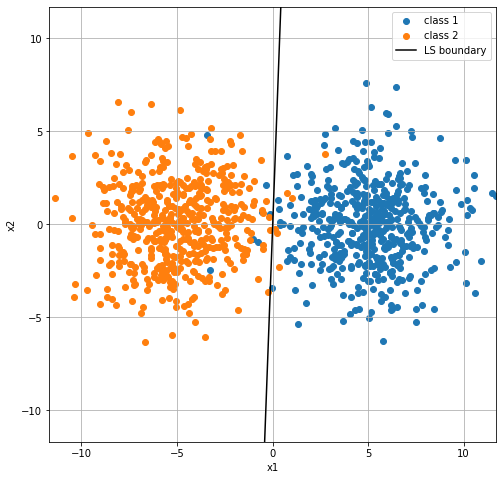

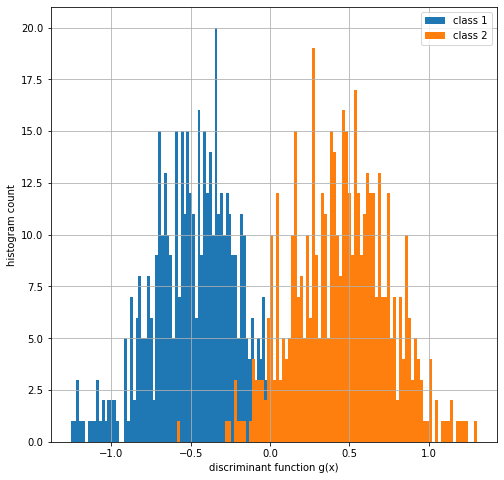

In [128]:
def solve_plot_ls_classifier(x, labels):
    N = x.shape[0]
    X_tilde = np.ones((N, 3))   ## the feature vector is dimension 2, and this is the extended version   
    X_tilde[:, 1:] = x          ## the first column is all 1s, this sets the rest of each row to the data samples
    y = (-1.0) ** labels        ## (-1)^(1 + 1) = +1 and (-1)^(2+1) = -1, maps class 1 and class 2 to +1, -1, resp.
    w_ls, Re, rank, singular_vals = np.linalg.lstsq(X_tilde, y, rcond=None)

    plt.figure(figsize=(8, 8))
    LIMIT = np.max(x)
    x_1 = x[labels==1]
    x_2 = x[labels==2]
    x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
    plt.scatter(x_1.T[0], x_1.T[1], label='class 1')
    plt.scatter(x_2.T[0], x_2.T[1], label='class 2')
    ## plot the decision boundary which is g(x) = 0
    plt.plot( x_plot, -1 * ( w_ls[1] *  x_plot  + w_ls[0] ) / w_ls[2], c='k', label='LS boundary')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(':')
    plt.xlim([-LIMIT, LIMIT])
    plt.ylim([-LIMIT, LIMIT])

    plt.figure(figsize=(8, 8))
    g1 = x_1 @ w[1:] + w[0]
    g2 = x_2 @ w[1:] + w[0]
    _ = plt.hist(g1, bins = 100, label='class 1')
    _ = plt.hist(g2, bins = 100, label='class 2')
    plt.legend()
    plt.grid(':')
    plt.xlabel('discriminant function g(x)')
    plt.ylabel('histogram count')

print(f'w = {w}')
solve_plot_ls_classifier(x, labels)

## Relation to Nearest Means Classifier
Note that the nearest means classifier considered last time is of this form since.  Specifically, we would decide class 1 if
$$\| {\bf x} - \underline{\mu}_2 \|^2 - \| {\bf x} - \underline{\mu}_1 \|^2 > 0$$
This can be expanded to 
 $$\| {\bf x} - \underline{\mu}_2 \|^2 - \| {\bf x} - \underline{\mu}_1 \|^2 = 2 (\underline{\mu}_1 - \underline{\mu}_2)^T {\bf x} + \| \underline{\mu}_2 \|^2 -  \| \underline{\mu}_1 \|^2$$
It follows that the discriminant for the nearest means classifier is
$$g({\bf x}) =  (\underline{\mu}_1 - \underline{\mu}_2)^T {\bf x}  + \frac{1}{2} \left(  \| \underline{\mu}_2 \|^2 -  \| \underline{\mu}_1 \|^2  \right)$$

So, these are both linear classifiers and they use different criteria to select the values of $\{ w_i \}$.  

Let's do some examples to compare.  


w vector for LS: [-0.00161074  0.16558762 -0.00599575]
w vector for NM: [-0.11053672 10.0670322  -0.11262997]



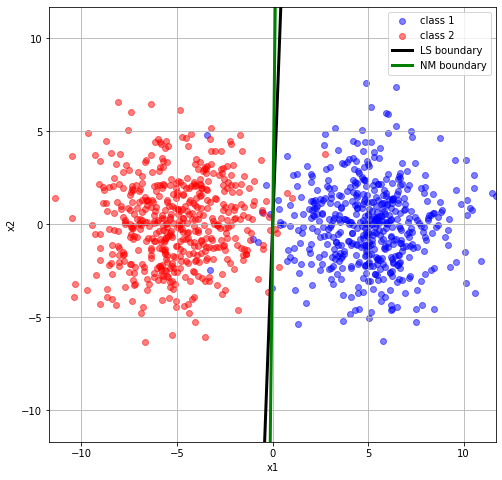

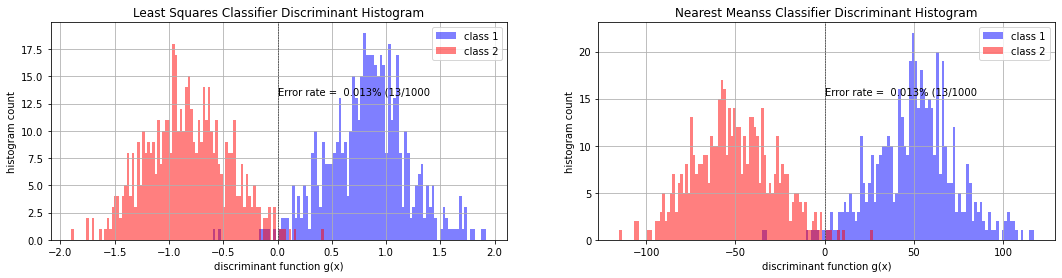

In [130]:
def solve_plot_ls_nm_classifier(x, labels):
    ## LS classifier
    N = x.shape[0]
    X_tilde = np.ones((N, 3))   ## the feature vector is dimension 2, and this is the extended version   
    X_tilde[:, 1:] = x          ## the first column is all 1s, this sets the rest of each row to the data samples
    y = (-1.0) ** (labels + 1)        ## (-1)^(1 + 1) = +1 and (-1)^(2+1) = -1, maps class 1 and class 2 to +1, -1, resp.
    w_ls, Re, rank, singular_vals = np.linalg.lstsq(X_tilde, y, rcond=None)

    ## Nearest Means Classifier:
    x_1 = x[labels==1]
    x_2 = x[labels==2]
    mu1 = np.mean(x_1, axis=0)
    mu2 = np.mean(x_2, axis=0)
    w_nm = np.ones(3)
    w_nm[0] = 0.5 * (np.dot(mu2, mu2) - np.dot(mu1, mu1))
    w_nm[1:] = mu1 - mu2

    plt.figure(figsize=(8, 8))
    LIMIT = np.max(x)
    x_plot = np.arange(-1 * LIMIT, LIMIT, 0.01)
    plt.scatter(x_1.T[0], x_1.T[1], fc=(0, 0, 1, 0.5), label='class 1')
    plt.scatter(x_2.T[0], x_2.T[1], fc=(1, 0, 0, 0.5), label='class 2')
    ## plot the decision boundaries which is g(x) = 0
    plt.plot( x_plot, -1 * ( w_ls[1] *  x_plot  + w_ls[0] ) / w_ls[2], linewidth=3, c='k', label='LS boundary')
    plt.plot( x_plot, -1 * ( w_nm[1] *  x_plot  + w_nm[0] ) / w_nm[2], linewidth=3, c='g', label='NM boundary')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-LIMIT, LIMIT])
    plt.ylim([-LIMIT, LIMIT])
    plt.legend()
    plt.grid(':')

    fig, ax = plt.subplots(1, 2, sharex=False, figsize=(18, 4))
    titles = ['Least Squares Classifier Discriminant Histogram', 'Nearest Meanss Classifier Discriminant Histogram']
    for i, w in enumerate([w_ls, w_nm]):
        g1 = x_1 @ w[1:] + w[0]
        g2 = x_2 @ w[1:] + w[0]
        h1 = ax[i].hist(g1, bins = 100, fc=(0, 0, 1, 0.5), label='class 1')
        h2 = ax[i].hist(g2, bins = 100, fc=(1, 0, 0, 0.5), label='class 2')
        N1_errors = np.sum(g1 < 0)
        N2_errors = np.sum(g2 >= 0)
        error_rate = (N1_errors + N2_errors) / N
        ax[i].axvline(0, linewidth=0.5, linestyle='dashed', color='k')
        
        ax[i].grid(':')
        ax[i].legend()
        ax[i].set_xlabel('discriminant function g(x)')
        ax[i].set_ylabel('histogram count')
        ax[i].set_title(titles[i])
        peak = np.maximum(np.max(h1[0]), np.max(h2[0]))
        ax[i].text(0, 0.7 * peak, f'Error rate = {error_rate : 0.3f}% ({N1_errors + N2_errors}/{N}')
    
        # print(f'Error rate = {error_rate : 0.3f}%')


    print(f'\nw vector for LS: {w_ls}')
    print(f'w vector for NM: {w_nm}\n')


solve_plot_ls_nm_classifier(x, labels)

Let's look at some Gaussina data that has directional preference:


w vector for LS: [-0.01119597  0.2852818  -0.19057011]
w vector for NM: [-0.40758777  5.83889014 -0.14494313]



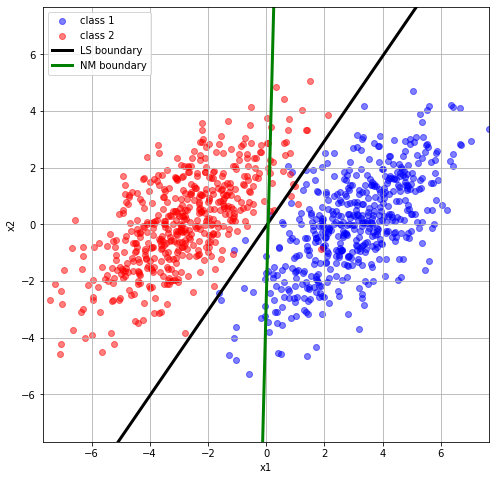

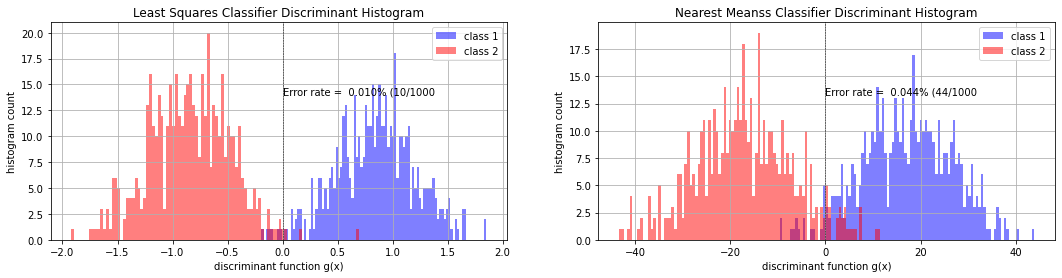

In [131]:
means = np.asarray( [ [3, 0], [-3, 0] ])
lambdas = np.asarray( [ [5, 1], [5, 1] ])  
thetas = np.asarray([ np.pi / 4, np.pi / 4 ])
Ns = np.asarray([500, 500])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')

solve_plot_ls_nm_classifier(x, labels)

Now with expoenntial data


w vector for LS: [-0.01217516  0.2852259  -0.21321778]
w vector for NM: [-0.67385412  6.21863528  0.31596458]



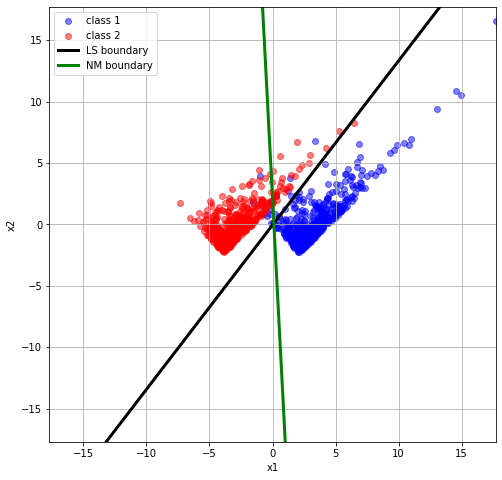

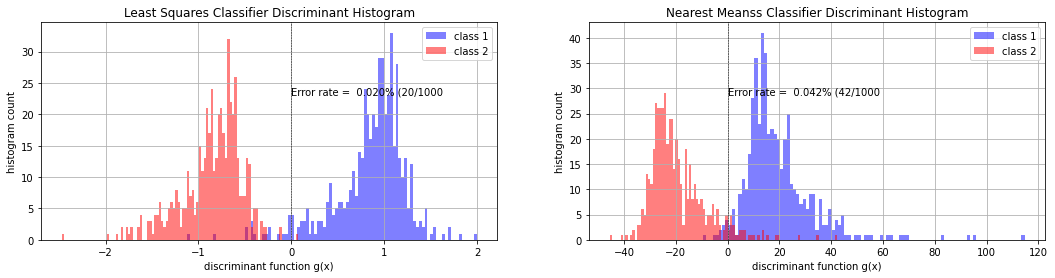

In [132]:
means = np.asarray( [ [3, 0], [-3, 0] ])
lambdas = np.asarray( [ [5, 1], [5, 1] ])  
thetas = np.asarray([ np.pi / 4, np.pi / 4 ])
Ns = np.asarray([500, 500])

x, labels, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='exponential')

solve_plot_ls_nm_classifier(x, labels)